# Exercise Sheet 3 - Convolutional Neural Networks on MNIST + Batch Normalization

 * Deep Learning – Winter term 2019/20
 * Instructor: Prof. Dr. Alexander Ecker
 * Tutors: Pronaya Prosun Das, Samaneh Sadegh and Muhammad Jazib Zafar
 * Due date: Jan 13, 2020 at noon

In this assignment you will learn how to train a Convolutional Neural Network to classify images. We will work with the MNIST hand-written digits dataset.
The goals of this assignment are as follows:

*   Exploring the architecture of CNNs like number of features, kernel sizes and pooling.
*   Understanding the impact of batch normalization.
*   Creating custom `nn.Module` in PyTorch.

### IMPORTANT SUBMISSION INSTRUCTIONS

- When you're done, download the notebook and rename it to \<surname1\>_\<surname2\>_\<surname3\>.ipynb
- Only submit the ipynb file, no other file is required
- Submit only once
- The deadline is strict
- You are required to present your solution in the tutorial; submission of the notebook alone is not sufficient

Implementation
- Only change code to replace placeholders. Leave the other code as is.



### **PART 1**

**Importing required libraries.**

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as ds
import torchvision.transforms as T
import pathlib
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import time
import os

**load dataset.**

We use the MNIST dataset. This might take a couple minutes the first time you do it. Use appropriate training and validation samples.
 

In [2]:
#seed is important for reproducibility
seed = 42
np.random.seed(seed)
print(torch.manual_seed(seed))

mnist_transforms = T.Compose([T.ToTensor(), T.Normalize((0.1307,), (0.3081,))])

batch_size = 256
# Load MNIST dataset
mnist_trainset = ds.MNIST(root='./data', train=True, download=True, transform=mnist_transforms)
train_size = int(0.8 * len(mnist_trainset))
val_size = len(mnist_trainset) - train_size
train_set, val_set = torch.utils.data.random_split(mnist_trainset, [train_size, val_size])

trainloader = DataLoader(train_set, batch_size=batch_size,
                         shuffle=True, num_workers=2)
valloader = DataLoader(val_set, batch_size=batch_size,
                        shuffle=True, num_workers=2)
mnist_testset = ds.MNIST(root='./data', train=False, download=True, transform=mnist_transforms)
testloader = DataLoader(mnist_testset, batch_size=batch_size,
                        shuffle=True, num_workers=2)

**Define a model.**

The first step to training a model is defining its architecture. 
Use `nn.Sequential` to define a model with following structure:
![Imgur](https://i.imgur.com/7LfRN2y.jpg)
*   Convolutional layer with 32 filters, kernel size of 5*5 and stride of 1.
*   Max Pooling layer with kernel size of 2*2 and default stride (2).
*   ReLU activation function.
*   Linear layer with output of 512.
*   ReLU activation function.
*   A linear layer with output of 10.
*   At the end put a softmax activation.

In [3]:
#self.net = nn.Sequential(
#    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=1),
#    nn.MaxPool2d(2, 2),
#    nn.ReLU(),
#    nn.Linear(in_features=32*12*12, out_features=512),
#    nn.ReLU(),
#    nn.Linear(in_features=512, out_features=10),
#    nn.Softmax()
#)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu1 = nn.ReLU()
        self.fc1 = nn.Linear(32 * 12 * 12, 512)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(512, 10)
        self.softmax = nn.Softmax()###softmax raus

    def forward(self, x):
        x = self.relu1(self.pool(self.conv1(x)))
        # Changing view because for executing the 3d-tensor as a 1d tensor in the linear layers
        x = x.view(x.shape[0], 32 * 12 * 12)
        x = self.relu2(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x


net = Net()
if os.path.exists("./mnist_classifier_model.pth"):
    net.load_state_dict(torch.load("./mnist_classifier_model.pth"))

In [4]:
net

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu1): ReLU()
  (fc1): Linear(in_features=4608, out_features=512, bias=True)
  (relu2): ReLU()
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (softmax): Softmax(dim=None)
)

**Train the model**

Use the cross-entropy loss and set up an optimizer with appropriate parameters.

In [5]:
loss_method = nn.CrossEntropyLoss() #softmax wird hier praktisch automatisch mit aufgenommen
optimizer = optim.SGD(net.parameters(), lr=1e-04, momentum=9e-01)

Train the model using datasets. Run the training for at least 10 epoch. Show validation accuracy and loss in each epoch. Also monitor training accuracy and loss.

In [6]:
def accuracy_fn(correct, total):
    return float(correct)/total

def train(dataloader, model, device, optimizer, loss_fn, train_loss):
    epoch_loss = []
    epoch_correct = 0
    epoch_total = 0
    for x, y in dataloader:
        optimizer.zero_grad()
        model.train()
        y_pred = model(x.to(device))
        hits = y.to(device) == y_pred.argmax(dim=1).to(device)
        epoch_correct += sum(hits)
        epoch_total += len(hits)
        loss = loss_fn(y_pred.to(device), y.to(device))
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
        averaged_loss = sum(epoch_loss[-50:])/len(epoch_loss[-50:])
    train_loss.extend(epoch_loss)
    epoch_accuracy = accuracy_fn(epoch_correct, epoch_total)
    return epoch_loss, epoch_accuracy


def validate(dataloader, model, device, loss_fn, val_loss):
    epoch_loss = []
    confusion = torch.zeros(10, 10)
    epoch_correct = 0
    epoch_total = 0
    epoch_misclassified = []
    confusion = torch.zeros(10, 10, dtype=torch.int32)
    for x, y in dataloader:
        model.eval()
        y_pred = model(x.to(device))
        y_pred_idxs = y_pred.argmax(dim=1)
        for (idx_true, idx_pred) in zip(y, y_pred_idxs):
            confusion[idx_true, idx_pred] += 1
        hits = y.to(device) == y_pred_idxs.to(device)
        epoch_correct += sum(hits)
        epoch_total += len(hits)
        misclassified = list(zip([x for x in x[~hits]], y[~hits]))
        epoch_misclassified.extend(misclassified)
        loss = loss_fn(y_pred, y.to(device))
        epoch_loss.append(loss.item())
        averaged_loss = sum(epoch_loss[-50:])/len(epoch_loss[-50:])
    epoch_accuracy = accuracy_fn(epoch_correct, epoch_total)
    return epoch_loss, epoch_accuracy, epoch_misclassified, confusion
    

In [7]:
def load(path):
    if not os.path.exists(path):
        loss = []
    else:
        loss = list(np.loadtxt(path, delimiter=','))
    return loss

def save(path, x):
    np.savetxt(path, x, delimiter=',')

if not os.path.exists("./losses"):
    os.mkdir("./losses")

train_loss = load("./losses/loss.out")
val_loss = load("./losses/val_loss.out")
epochs_train_losses = load("./losses/epochs_loss.out")
epochs_val_losses = load("./losses/epochs_val_loss.out")
epochs_train_accuracies = load("./losses/epochs_train_accuracy.out")
epochs_val_accuracies = load("./losses/epochs_val_accuracy.out")


In [ ]:
use_cuda = False
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'

n_epochs = 30

start_time = time.time()
for epoch in range(n_epochs):
    epoch_train_loss, epoch_train_accuracy = train(dataloader=trainloader,
                           model=net,
                           device=device,
                           optimizer=optimizer,
                           loss_fn=loss_method,
                           train_loss=train_loss)
    epoch_train_mean_loss = sum(epoch_train_loss)/len(epoch_train_loss)
    epochs_train_losses.append(epoch_train_mean_loss)
    epochs_train_accuracies.append(epoch_train_accuracy)
    epoch_val_loss, epoch_val_acc, misclassified, confusion = validate(dataloader=valloader,
                                                                       model=net,
                                                                       device=device,
                                                                       loss_fn=loss_method,
                                                                       val_loss=val_loss)
    epoch_val_mean_loss = sum(epoch_val_loss)/len(epoch_val_loss)
    epochs_val_losses.append(epoch_val_mean_loss)
    epochs_val_accuracies.append(epoch_val_acc)
    print(f"Epoch: {epoch}| loss={epoch_train_mean_loss}; accuracy={epoch_train_accuracy}; val_loss={epoch_val_mean_loss}; val_accuracy={epoch_val_acc}")

print("--- execution time in seconds : %s ---" % (time.time() - start_time))
PATH = './mnist_classifier_model.pth'
torch.save(net.state_dict(), PATH)


save("./losses/loss.out", np.array(train_loss))
save("./losses/val_loss.out", np.array(val_loss))
save("./losses/epochs_loss.out", np.array(epochs_train_losses))
save("./losses/epochs_val_loss.out", np.array(epochs_val_losses))
save("./losses/epochs_train_accuracy.out", np.array(epochs_train_accuracies))
save("./losses/epochs_val_accuracy.out", np.array(epochs_val_accuracies))


C:\Users\Katharina_2019\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0| loss=1.6919292414442022; accuracy=0.818875; val_loss=1.6929075565743954; val_accuracy=0.81525
Epoch: 1| loss=1.6878152026775035; accuracy=0.8201875; val_loss=1.6889721535621804; val_accuracy=0.8165833333333333


**Show plots**

Show the Epoch Vs Accuracy and Epoch Vs Validation Loss plot from the previous training.

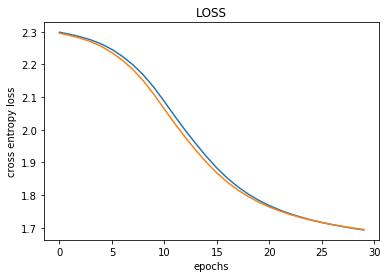

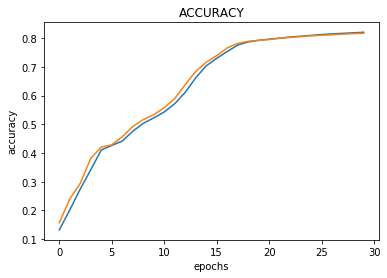

In [0]:
plt.figure(1)
plt.title("LOSS")
plt.plot(load("./losses/epochs_loss.out"))
plt.plot(load("./losses/epochs_val_loss.out"))
plt.xlabel('epochs')
plt.ylabel('cross entropy loss')
plt.show()

plt.figure(2)
plt.title("ACCURACY")
plt.plot(load("./losses/epochs_train_accuracy.out"))
plt.plot(load("./losses/epochs_val_accuracy.out"))
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

**Check the accuracy of the model.**

Check the accuracy of the model using test dataset: loader_test.

In [0]:
def check_accuracy(dataloader, model, device):
    epoch_loss = []
    confusion = torch.zeros(10, 10)
    epoch_correct = 0
    epoch_total = 0
    epoch_misclassified = []
    confusion = torch.zeros(10, 10, dtype=torch.int32)
    for x, y in dataloader:
        model.eval()
        y_pred = model(x.to(device))
        y_pred_idxs = y_pred.argmax(dim=1)
        for (idx_true, idx_pred) in zip(y, y_pred_idxs):
            confusion[idx_true, idx_pred] += 1
        hits = y.to(device) == y_pred_idxs.to(device)
        epoch_correct += sum(hits)
        epoch_total += len(hits)
        misclassified = list(zip([x for x in x[~hits]], y[~hits]))
        epoch_misclassified.extend(misclassified)
    accuracy = accuracy_fn(epoch_correct, epoch_total)
    return accuracy, misclassified, confusion

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


ACC: 0.8286


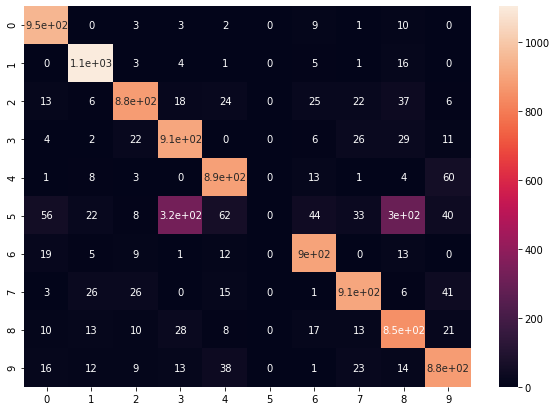

In [0]:
import seaborn as sn
accuracy, misclassified, confusion = check_accuracy(testloader, net, device)
print(f"ACC: {accuracy}")
plt.figure(figsize=(10, 7))
sn.heatmap(confusion, annot=True)

**bold text**### **PART 2**

We now add batch normalization to the convolutional layer and dropout to the fully-connected layer. Both should improve performance of the model.

**Batch Normalization**

Normalization is done to adjust and scale the activations. For example, when we have features from 0 to 1 and some from 1 to 1000, we should normalize them to speed up learning. If the input layer is benefiting from it, the same should also hold for the values in the hidden layers. Batch normalization improves training speed and stabilizes training by avoiding vanishing or exploding gradients.

**Dropout**

Dropout is a regularization method. It temporarily removes a unit from the network, along with all its incoming and outgoing connections. 

**Task**

Add batch normalization after convolutional layer and put a dropout layer with probality 0.6 after the first linear layer.


In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.batch_norm = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu1 = nn.ReLU()
        self.fc1 = nn.Linear(32 * 12 * 12, 512)
        self.dropout = nn.Dropout(0.6)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(512, 10)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.relu1(self.pool(self.batch_norm(self.conv1(x))))
        # Changing view because for executing the 3d-tensor as a 1d tensor in the linear layers
        x = x.view(x.shape[0], 32 * 12 * 12)
        x = self.relu2(self.dropout(self.fc1(x)))
        x = self.softmax(self.fc2(x))
        return x


if not os.path.exists("./mnist_classifier_model_batch_norm.pth"):
    net_bn = Net()
else:
    net_bn = Net()
    net_bn.load_state_dict(torch.load("./mnist_classifier_model_batch_norm.pth"))

Train the model again with the same loss function and optimizer. Just call the train function you have written earlier.

In [0]:
# Your loss function and optimizer
loss_method = nn.CrossEntropyLoss()
optimizer2 = optim.SGD(net_bn.parameters(), lr=1e-04, momentum=9e-01)


In [0]:
if not os.path.exists("./losses_batch_norm"):
    os.mkdir("./losses_batch_norm")

n_epochs = 10

train_loss_bn = load("./losses_batch_norm/loss.out")
val_loss_bn = load("./losses_batch_norm/val_loss.out")
epochs_train_losses_bn = load("./losses_batch_norm/epochs_loss.out")
epochs_val_losses_bn = load("./losses_batch_norm/epochs_val_loss.out")
epochs_train_accuracies_bn = load("./losses_batch_norm/epochs_train_accuracy.out")
epochs_val_accuracies_bn = load("./losses_batch_norm/epochs_val_accuracy.out")


start_time = time.time()

for epoch in range(n_epochs):
    epoch_train_loss, epoch_train_accuracy = train(dataloader=trainloader,
                           model=net_bn,
                           device=device,
                           optimizer=optimizer,
                           loss_fn=loss_method,
                           train_loss=train_loss_bn)
    epoch_train_mean_loss = sum(epoch_train_loss)/len(epoch_train_loss)
    epochs_train_losses_bn.append(epoch_train_mean_loss)
    epochs_train_accuracies_bn.append(epoch_train_accuracy)
    epoch_val_loss, epoch_val_acc, misclassified, confusion = validate(dataloader=valloader,
                                                                       model=net_bn,
                                                                       device=device,
                                                                       loss_fn=loss_method,
                                                                       val_loss=val_loss_bn)
    epoch_val_mean_loss = sum(epoch_val_loss)/len(epoch_val_loss)
    epochs_val_losses_bn.append(epoch_val_mean_loss)
    epochs_val_accuracies_bn.append(epoch_val_acc)
    print(f"Epoch: {epoch}| loss={epoch_train_mean_loss}; accuracy={epoch_train_accuracy}; val_loss={epoch_val_mean_loss}; val_accuracy={epoch_val_acc}")

print("--- execution time in seconds : %s ---" % (time.time() - start_time))
PATH = './mnist_classifier_model_batch_norm.pth'
torch.save(net.state_dict(), PATH)


save("./losses_batch_norm/loss.out", np.array(train_loss_bn))
save("./losses_batch_norm/val_loss.out", np.array(val_loss_bn))
save("./losses_batch_norm/epochs_loss.out", np.array(epochs_train_losses_bn))
save("./losses_batch_norm/epochs_val_loss.out", np.array(epochs_val_losses_bn))
save("./losses_batch_norm/epochs_train_accuracy.out", np.array(epochs_train_accuracies_bn))
save("./losses_batch_norm/epochs_val_accuracy.out", np.array(epochs_val_accuracies_bn))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0| loss=1.7494283705315692; accuracy=0.7766875; val_loss=1.7213146153916703; val_accuracy=0.8018333333333333
Epoch: 1| loss=1.7410300925691078; accuracy=0.7815625; val_loss=1.7142161663542403; val_accuracy=0.8055833333333333
Epoch: 2| loss=1.7354073930293956; accuracy=0.782375; val_loss=1.707402396709361; val_accuracy=0.8084166666666667
Epoch: 3| loss=1.7267008056031896; accuracy=0.7891458333333333; val_loss=1.7010310736108334; val_accuracy=0.8106666666666666
Epoch: 4| loss=1.7211108049179644; accuracy=0.792; val_loss=1.6958452260240595; val_accuracy=0.81325
Epoch: 5| loss=1.7149713350103257; accuracy=0.7971875; val_loss=1.6900069992592994; val_accuracy=0.8163333333333334
Epoch: 6| loss=1.7084956999788894; accuracy=0.8020208333333333; val_loss=1.6834626299269655; val_accuracy=0.8244166666666667
Epoch: 7| loss=1.7023900867776667; accuracy=0.8089166666666666; val_loss=1.6757406351414132; val_accuracy=0.8360833333333333
Epoch: 8| loss=1.694213402398089; accuracy=0.8221875; val_loss

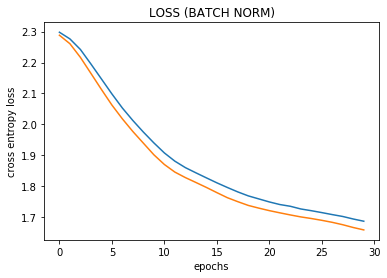

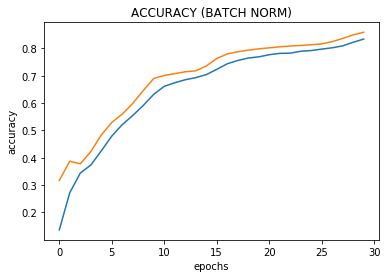

In [0]:
plt.figure(1)
plt.title("LOSS (BATCH NORM)")
plt.plot(load("./losses_batch_norm/epochs_loss.out"))
plt.plot(load("./losses_batch_norm/epochs_val_loss.out"))
plt.xlabel('epochs')
plt.ylabel('cross entropy loss')
plt.show()

plt.figure(2)
plt.title("ACCURACY (BATCH NORM)")
plt.plot(load("./losses_batch_norm/epochs_train_accuracy.out"))
plt.plot(load("./losses_batch_norm/epochs_val_accuracy.out"))
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

Is there any change in train, validation and test accuracy?

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


ACC: 0.8709


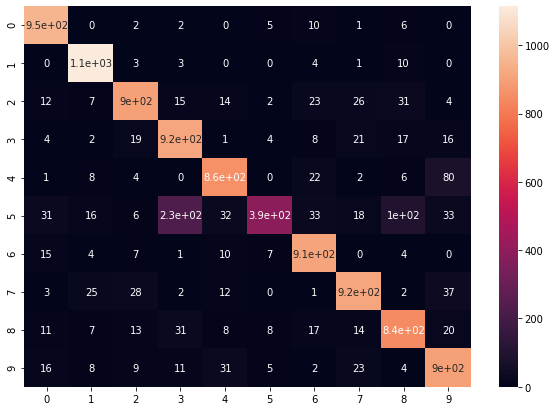

In [0]:
import seaborn as sn
accuracy, misclassified, confusion = check_accuracy(testloader, net_bn, device)
print(f"ACC: {accuracy}")
plt.figure(figsize=(10, 7))
sn.heatmap(confusion, annot=True)

### **PART 3**

In this section we implement a model with multiple convolutional layers and train using GPU (if available).

Implement the following architecture by subclassing `nn.Module`:

![Imgur](https://imgur.com/rpBqY43.png)

**Setting Free GPU**

Go to Edit > Notebook settings or Runtime > Change runtime type and select GPU as Hardware accelerator.

![Imgur](https://imgur.com/wGchqmj.png)

For details, please read the 
[this](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d)
article.

Also you have to move all the tensors to the GPU, otherwise it will run on CPU. Train the model for at least 10 epoch.

In [0]:
# Define the model
class CustomModel(torch.nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.features1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 5, 1),
            nn.MaxPool2d(3),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.features2 = nn.Sequential(
            nn.Conv2d(1, 128, 7, 1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        self.classifier = nn.Sequential(
            nn.Linear(16064, 1000),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(1000, 10),
            nn.Softmax()
        )



    def forward(self, x):
        f1 = self.features1(x)
        f2 = self.features2(x)
        f1 = f1.view(f1.shape[0], f1.shape[1] * f1.shape[2] * f1.shape[3])
        f2 = f2.view(f2.shape[0], f2.shape[1] * f2.shape[2] * f2.shape[3])
        concat = torch.cat((f1, f2), dim=1)
        out = self.classifier(concat)
        return out


# Instantiate the model
cnn = CustomModel()

# Utilize GPU
device = torch.device('cuda:0')
cnn = cnn.to(device)

Define the loss function and optimizer,

In [0]:
loss_fn = nn.CrossEntropyLoss()
optimizer3 = optim.SGD(cnn.parameters(), lr=1e-04, momentum=9e-01)

Call the train function you have written earlier.

In [0]:
if not os.path.exists("./losses_cnn"):
    os.mkdir("./losses_cnn")

n_epochs = 10

NEW = True

train_loss = [] if NEW else load("./losses_cnn/loss.out")
val_loss = [] if NEW else load("./losses_cnn/val_loss.out")
epochs_train_losses = [] if NEW else load("./losses_cnn/epochs_loss.out")
epochs_val_losses = [] if NEW else load("./losses_cnn/epochs_val_loss.out")
epochs_train_accuracies = [] if NEW else load("./losses_cnn/epochs_train_accuracy.out")
epochs_val_accuracies = [] if NEW else load("./losses_cnn/epochs_val_accuracy.out")


start_time = time.time()

for epoch in range(n_epochs):
    epoch_train_loss, epoch_train_accuracy = train(dataloader=trainloader,
                           model=cnn,
                           device=device,
                           optimizer=optimizer3,
                           loss_fn=loss_method,
                           train_loss=train_loss)
    epoch_train_mean_loss = sum(epoch_train_loss)/len(epoch_train_loss)
    epochs_train_losses.append(epoch_train_mean_loss)
    epochs_train_accuracies.append(epoch_train_accuracy)
    epoch_val_loss, epoch_val_acc, misclassified, confusion = validate(dataloader=valloader,
                                                                       model=cnn,
                                                                       device=device,
                                                                       loss_fn=loss_method,
                                                                       val_loss=val_loss)
    epoch_val_mean_loss = sum(epoch_val_loss)/len(epoch_val_loss)
    epochs_val_losses.append(epoch_val_mean_loss)
    epochs_val_accuracies.append(epoch_val_acc)
    print(f"Epoch: {epoch}| loss={epoch_train_mean_loss}; accuracy={epoch_train_accuracy}; val_loss={epoch_val_mean_loss}; val_accuracy={epoch_val_acc}")

print("--- execution time in seconds : %s ---" % (time.time() - start_time))
PATH = './mnist_classifier_model_batch_norm.pth'
torch.save(net.state_dict(), PATH)


save("./losses_cnn/loss.out", np.array(train_loss))
save("./losses_cnn/val_loss.out", np.array(val_loss))
save("./losses_cnn/epochs_loss.out", np.array(epochs_train_losses))
save("./losses_cnn/epochs_val_loss.out", np.array(epochs_val_losses))
save("./losses_cnn/epochs_train_accuracy.out", np.array(epochs_train_accuracies))
save("./losses_cnn/epochs_val_accuracy.out", np.array(epochs_val_accuracies))


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 0| loss=2.2660230537678334; accuracy=0.28789583333333335; val_loss=2.191907801526658; val_accuracy=0.5696666666666667
Epoch: 1| loss=2.0842791681594037; accuracy=0.5909166666666666; val_loss=1.9657418778602114; val_accuracy=0.6875833333333333
Epoch: 2| loss=1.9010300769450816; accuracy=0.7173541666666666; val_loss=1.823095440864563; val_accuracy=0.7814166666666666
Epoch: 3| loss=1.7969584712322721; accuracy=0.7826458333333334; val_loss=1.7492693053915145; val_accuracy=0.81375
Epoch: 4| loss=1.7385995831895382; accuracy=0.8209375; val_loss=1.7003439335112875; val_accuracy=0.8551666666666666
Epoch: 5| loss=1.6966434203563852; accuracy=0.8558958333333333; val_loss=1.6657489081646533; val_accuracy=0.8806666666666667
Epoch: 6| loss=1.667514463054373; accuracy=0.8729166666666667; val_loss=1.6427974878473486; val_accuracy=0.8904166666666666
Epoch: 7| loss=1.648412524385655; accuracy=0.8818958333333333; val_loss=1.6260951326248494; val_accuracy=0.8994166666666666
Epoch: 8| loss=1.632669

Show the accuracy by calling check_accuracy(...)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


ACC: 0.9204


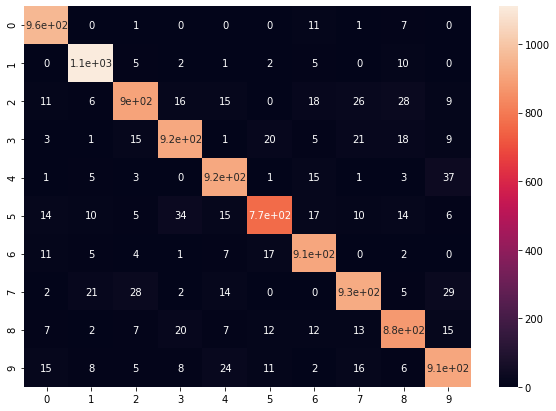

In [0]:
import seaborn as sn
accuracy, misclassified, confusion = check_accuracy(testloader, cnn, device)
print(f"ACC: {accuracy}")
plt.figure(figsize=(10, 7))
sn.heatmap(confusion, annot=True)

#### [OPTIONAL]
Can you get the performance of the CNN to 99.5% with the above architecture? If not, can you change it to improve performance? Note that state-of-the-art performance on MNIST with CNNs is around 99.8% accuracy.

In [0]:
# TODO